## Compressing one-hot encodings - autoencoder

Want to experiment with adding them to the GCN. First here we experiment with an autoencoder style setup. The loss converges quickly, but comparing the output to the truth, shows the model isn't reproducing the data at all. The input size is probably too large to do this for such a small training sample.

In [1]:
import sys
sys.path.insert(0, "..")
import TCGAData, numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import seaborn as sns
import tqdm
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

root = "/mnt/home/sgolkar/projects/cancer-net/data/brain"
files = "/mnt/home/sgolkar/projects/cancer-net/data/brain/samples.txt"
label_mapping = ["LGG", "GBM"]
dataset = TCGAData.TCGADataset(
    root=root,
    files=files,
    label_mapping=label_mapping,
    gene_graph="brain.geneSymbol.gz",test_ratio=0,
)

In [2]:
gene_dict = {
    el: i
    for i, el in enumerate(
        set([item for sublist in dataset.data.node_id for item in sublist])
    )
}
num_genes = len(gene_dict)

Xmutated = np.zeros((dataset.num_samples, num_genes))
Xmutnorm = np.zeros((dataset.num_samples, num_genes))


for sample_num in range(dataset.num_samples):
    sample_data = dataset.get(sample_num)
    for encoding, sample_gene in zip(sample_data.x, sample_data.node_id):
        Xmutated[sample_num, gene_dict[sample_gene]] = 1
        Xmutnorm[sample_num, gene_dict[sample_gene]] = np.linalg.norm(encoding)

Xmutatedv2 = (Xmutnorm != 0).astype(float)

In [4]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(num_genes, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64)
        )
          
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(64, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, num_genes),
            torch.nn.Sigmoid()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [13]:
# Model Initialization
model = AE()
model.float()
  
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
  
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-4,
                             weight_decay = 1e-8)

In [14]:
## Set data
valid_seed=0

dataset.set_valid_seed(valid_seed)

x_train = Xmutated[dataset.train_idx]
x_valid = Xmutated[dataset.valid_idx]

In [15]:
len(Xmutated[0])

15146

In [16]:
class MutDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, Xmutated):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.Xmutated=torch.from_numpy(Xmutated).float()

    def __len__(self):
        return len(self.Xmutated)

    def __getitem__(self, idx):
        return self.Xmutated[idx]

In [17]:
train_loader=DataLoader(MutDataset(x_train),batch_size=10)
valid_loader=DataLoader(MutDataset(x_valid),batch_size=10)

In [19]:
pred.shape

torch.Size([8, 15146])

In [20]:
loss = loss_function(pred, x)

In [21]:
loss.item()

0.24996806681156158

In [22]:
epochs = 50
outputs = []
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print("epoch:",epoch)
    t_loss=[]
    for x in train_loader:
        # Output of Autoencoder
        pred = model(x)
        
        # Calculating the loss function
        loss = loss_function(pred, x)
        
        
        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        
        # Storing the losses in a list for plotting
        t_loss.append(loss)
    loss_epoch=np.mean(np.array(t_loss))
    print("Training loss:",loss_epoch)
    train_loss.append(loss_epoch)
    #outputs.append((epochs, image, reconstructed))

epoch: 0
Training loss: 0.23753741336986423
epoch: 1
Training loss: 0.10743094366625883
epoch: 2
Training loss: 0.011444258139817975
epoch: 3
Training loss: 0.007109444995876402
epoch: 4
Training loss: 0.006377478614012944
epoch: 5
Training loss: 0.0060622556738962885
epoch: 6
Training loss: 0.005888131730898749
epoch: 7
Training loss: 0.005778266764536966
epoch: 8
Training loss: 0.005702968752302695
epoch: 9
Training loss: 0.005648482976539526
epoch: 10
Training loss: 0.0056076303553709295
epoch: 11
Training loss: 0.005576200990617508
epoch: 12
Training loss: 0.005551567726797657
epoch: 13
Training loss: 0.005531989518203773
epoch: 14
Training loss: 0.005516245415492449
epoch: 15
Training loss: 0.005503456901351456
epoch: 16
Training loss: 0.005492963373399107
epoch: 17
Training loss: 0.005484283323312411
epoch: 18
Training loss: 0.005477052254718728
epoch: 19
Training loss: 0.005470983836858068
epoch: 20
Training loss: 0.005465856458613416
epoch: 21
Training loss: 0.00546149918227456

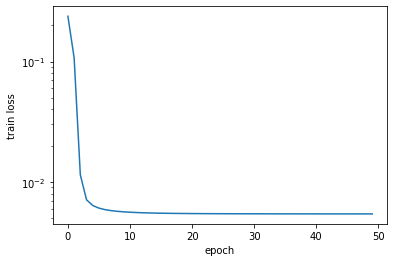

In [41]:
plt.plot(range(epochs),train_loss)
plt.ylabel("train loss")
plt.xlabel("epoch")
plt.yscale("log")

In [25]:
pred=model(x)

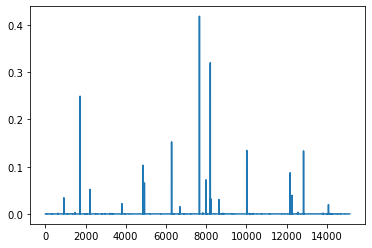

In [38]:
plt.plot(pred[0].detach().numpy())

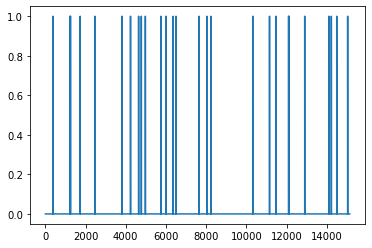

In [39]:
plt.plot(x[0].detach().numpy())

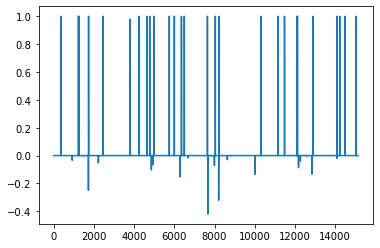

In [42]:
plt.plot(x[0].detach().numpy()-pred[0].detach().numpy())

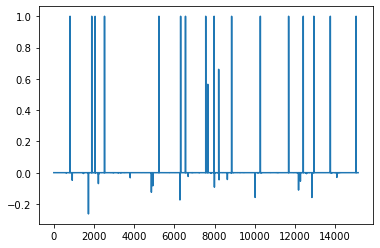

In [43]:
plt.plot(x[1].detach().numpy()-pred[1].detach().numpy())

In [ ]:
    for data in valid_loader:
        if not parall:
            data = data.to(device)
        output = model(data)
        output = output.squeeze()

        pred = output.max(1)[1]
        if parall:
            y = torch.cat([d.y for d in data]).to(output.device)
        else:
            y = data.y
        loss = criterion(output, y)
        total_loss += loss.item()

        correct += pred.eq(y).sum().item()
        num_samps += len(y)

In [ ]:
total_loss=0

In [ ]:
for (valid, _) in valid_loader:
    pred = model(valid)
    pred = pred.squeeze()
    valid_loss = loss_function(pred, valid)
    total_loss += valid_loss.item()
    valid_loss = total_loss/len(pred)

In [ ]:
len(pred)

In [ ]:
valid_loss.item()

In [ ]:
x_valid.shape

In [ ]:
x_train.shape

In [ ]:
638+112

In [ ]:
len(Xmutated)

In [ ]:
len(gene_dict)

In [ ]:
Xmutnorm[0][47]